# 導入套件

In [1]:
import numpy as np
import pandas as pd

# 載入並處理資料

In [2]:
data = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)
# 讀取檔案,將date設為index,若date的日期後面還有如幾點等時間,可用parse_dates = True 刪除,只留下日期
data = pd.DataFrame(data['AAPL.O'])
data.head()

,AAPL.O
Date,
2010-01-01,NaN
2010-01-04,30.572827
2010-01-05,30.625684
2010-01-06,30.138541
2010-01-07,30.082827


In [3]:
data.dropna(inplace = True) # 刪除有遺漏值之那列
data.head()

,AAPL.O
Date,
2010-01-04,30.572827
2010-01-05,30.625684
2010-01-06,30.138541
2010-01-07,30.082827
2010-01-08,30.282827


In [4]:
data['Return'] = np.log( data / data.shift() ) # 以連續型方式計算日報酬率
data.head() 

,AAPL.O,Return
Date,,
2010-01-04,30.572827,NaN
2010-01-05,30.625684,0.001727
2010-01-06,30.138541,-0.016034
2010-01-07,30.082827,-0.001850
2010-01-08,30.282827,0.006626


# 欲以落後6期(過去6天)之報酬率的漲or跌(正or負)為預測(解釋)變數，預測明天的漲跌
# (動量)

In [5]:
lags = 6
cols = [] 

for lag in range(1, lags + 1) :   # 想要新增6個欄位
    col = 'lag_{}'.format(lag)    # .format(lag) : 將lag值填入前面的{} 
    data[col] = np.sign(data['Return'].shift(lag))  
        # 新增欄位
        # 新增的欄位是將Return向下移lag格
        # sign : 若數值為正則返回1 ; 若數值為負責返回-1
        # shift(lag) : 以前lag格的Return去判斷正負 ( EX:在01-06之lag_1,前lag(1)格之Retrun為0.001727>0,故返回1
        #                                            在01-08之lag_2,前lag(2)格之Return為-0.016034<0,故返回-1 )                                           
    cols.append(col) # 後續另有用途
    
data.head(10)

D:\download\Anaconda\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


,AAPL.O,Return,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
Date,,,,,,,,
2010-01-04,30.572827,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,30.625684,0.001727,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,30.138541,-0.016034,1.0,NaN,NaN,NaN,NaN,NaN
2010-01-07,30.082827,-0.001850,-1.0,1.0,NaN,NaN,NaN,NaN
2010-01-08,30.282827,0.006626,-1.0,-1.0,1.0,NaN,NaN,NaN
2010-01-11,30.015684,-0.008861,1.0,-1.0,-1.0,1.0,NaN,NaN
2010-01-12,29.674256,-0.011440,-1.0,1.0,-1.0,-1.0,1.0,NaN
2010-01-13,30.092827,0.014007,-1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-14,29.918542,-0.005808,1.0,-1.0,-1.0,1.0,-1.0,-1.0


In [6]:
cols

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']

In [7]:
data.dropna(inplace = True) # 將有遺漏值之那列刪除
data.head()

,AAPL.O,Return,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
Date,,,,,,,,
2010-01-13,30.092827,0.014007,-1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-14,29.918542,-0.005808,1.0,-1.0,-1.0,1.0,-1.0,-1.0
2010-01-15,29.418542,-0.016853,-1.0,1.0,-1.0,-1.0,1.0,-1.0
2010-01-19,30.719969,0.043288,-1.0,-1.0,1.0,-1.0,-1.0,1.0
2010-01-20,30.246398,-0.015536,1.0,-1.0,-1.0,1.0,-1.0,-1.0


# 使用SVM設計交易策略

In [8]:
from sklearn.svm import SVC # 導入SVM

In [9]:
model = SVC(gamma = 'scale') # 設定參數 

In [10]:
model.fit( data[cols] , np.sign(data['Return']) )
    # .fit : 進行估計，此處將使用SVM預設的估計方法libsvm
    # data[cols] = X 解釋變數 (過去6期漲跌) 
    # np.sign(data['Return']) = Y 被解釋變數 (股票報酬率)

SVC()

In [11]:
data['Prediction'] = model.predict(data[cols])
    # .predict : 基於上面「.fit」的估計結果進行預測
    # 此處以過去六期的漲跌(正負)來預測下一期股票的漲跌(正負)，並將預測結果新增一個欄位到data中
    # 預測結果 = 1 : 明天(下期)股票會上漲
    # 預測結果 = -1 : 明天股票會下跌
data.head()

,AAPL.O,Return,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,Prediction
Date,,,,,,,,,
2010-01-13,30.092827,0.014007,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0
2010-01-14,29.918542,-0.005808,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2010-01-15,29.418542,-0.016853,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0
2010-01-19,30.719969,0.043288,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0
2010-01-20,30.246398,-0.015536,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0


In [12]:
data['Strategy'] = data['Prediction'] * data['Return']
    # Strategy : 策略之每日報酬率(亦可檢驗預測是否正確)
    # 預測正確 : Strategy之數值 > 0 , 因若預測正確 , Prediction與Retrun會同號 , 此時相乘 > 0
    # 預測錯誤 :Strategy之數值 < 0 , 因若預測錯誤 , Prediction與Retrun會異號 , 此時相乘 < 0
data.head()

,AAPL.O,Return,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,Prediction,Strategy
Date,,,,,,,,,,
2010-01-13,30.092827,0.014007,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,0.014007
2010-01-14,29.918542,-0.005808,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.005808
2010-01-15,29.418542,-0.016853,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-0.016853
2010-01-19,30.719969,0.043288,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,0.043288
2010-01-20,30.246398,-0.015536,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.015536


# 畫圖&結論

#### Retrun : 買進持有的策略
#### Strategy : 我們執行的策略 (未考慮交易成本)

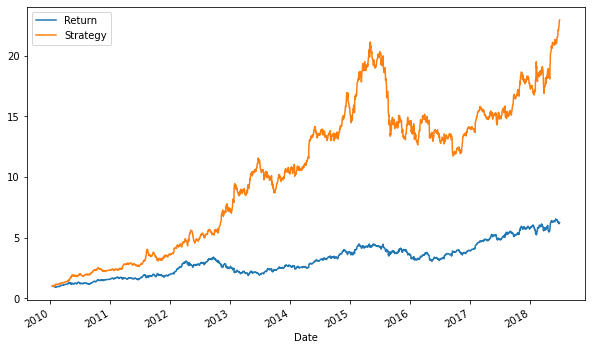

In [13]:
data[[ 'Return' , 'Strategy' ]].cumsum().apply(np.exp).plot( figsize = (10,6) )
    # .cumsum() : 將Return和Strategy這兩個欄位做加總 , 分別計算出「股票」和「策略」的總報酬率
    # .apply() : 將「.」前面的套用()裡的函數，此處即為將兩個總報酬率分別取自然指數，計算出本利和
    # .plot : 將「股票」和「策略」的本利和作圖
    # figsize(10,6) : 設定x軸長10 , Y軸長6

In [14]:
data[[ 'Return' , 'Strategy' ]].cumsum().apply(np.exp).tail() # 兩策略最後之本利和比較

,Return,Strategy
Date,,
2018-06-25,6.138991,22.406922
2018-06-26,6.215152,22.684902
2018-06-27,6.206053,22.718161
2018-06-28,6.251210,22.883464
2018-06-29,6.238067,22.931677


In [15]:
data['Transaction'] = np.where( data['Prediction'] != data['Prediction'].shift() , 1 , 0 )
    # Transaction : 數值為1代表有進行交易(買入or賣出股票)
    # where(x,y,z) : 若條件x成立則進行y ； 若條件x不成立則進行z
    # 若前後兩期預測漲跌不同(ex:昨天預測今天會上漲，今天預測明天會下跌)，則填入1 ; 反之則填0 
data.head()

,AAPL.O,Return,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,Prediction,Strategy,Transaction
Date,,,,,,,,,,,
2010-01-13,30.092827,0.014007,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,0.014007,1
2010-01-14,29.918542,-0.005808,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.005808,1
2010-01-15,29.418542,-0.016853,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-0.016853,1
2010-01-19,30.719969,0.043288,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,0.043288,0
2010-01-20,30.246398,-0.015536,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.015536,1


In [16]:
times = data['Transaction'].sum() 
print( '總共交易 {} 次'.format(times) )

總共交易 902 次
